In [48]:
window = 45
number_of_documents = 6

In [49]:
import urllib
from bs4 import BeautifulSoup

In [50]:
web_page = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

In [51]:
import requests 
import re

In [52]:
response = requests.get(web_page)

In [53]:
soup_obj = BeautifulSoup(response.text,'lxml')

In [54]:
links_nonprepared = soup_obj.find_all('a', href=re.compile('yellow_tripdata'))

In [55]:
links = []
for link in links_nonprepared:
    links.append(link.attrs['href'])

In [56]:
import csv
from contextlib import closing
import codecs

In [57]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime

In [58]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

In [59]:
class RollingMean():
    def __init__(self, window):
        self.dict = {} 
        self.window = window
        self.rolling_mean_results = []
        self.corrections = []
        self.late = []
        self.step = 0
        self.x = []
        self.y = []
        
        
    def handler(self,row_date,row_value):
        if row_date not in self.dict:
            self.dict[row_date]= { 'km'   : row_value, 'N': 1, 'mean' : row_value} 
        else:
            self.dict[row_date]= { 'km'   : self.dict[row_date]['km'] + row_value,
                                    'N'   : self.dict[row_date]['N']  + 1,
                                   'mean' : self.mean(row_value,
                                                      self.dict[row_date]['N'],
                                                      self.dict[row_date]['mean'])} 
        keys = list(self.dict.keys())
        if keys.index(row_date) < self.step:
            self.late.append([keys[self.step:],row_date])
            keys.sort()
            keys.sort()
            temp_keys = [x for x in keys if keys.index(row_date)-self.window+1 <= keys.index(x)
                         and keys.index(row_date) + self.window -1 >= keys.index(x)]
            self.rolling_mean(temp_keys, 0)
        keys.sort()
        keys = keys[self.step:]
        self.rolling_mean(keys, 1)
        
       
    def mean(self,new_sample, N, mean):
        mean -= mean / N;
        mean += new_sample / N;
        return mean;
    
    
    def rolling_mean(self,keys, count):
        self.mean_helper = self.dict[keys[0]]['mean']
        
        if self.window > len(keys):
            return
        
        if self.window < len(keys):
            for key in keys[:self.window]:
                self.mean_helper = self.mean(self.dict[key]['mean'],
                                             len(self.rolling_mean_results) + 1,
                                             self.mean_helper)
            self.step += count
            if count:
                self.rolling_mean_results.append((keys[:self.window], self.mean_helper))
                print((keys[:self.window],self.mean_helper),"\n")
                self.plot(len(self.rolling_mean_results) + 1, self.mean_helper)
            else:
                self.corrections.append((keys[:self.window], self.mean_helper))
            self.rolling_mean(keys[1:], count)
            
    def process_data(self,row,input_date):
        date = row[1].rsplit(" ",1)[0]
        match = re.search('\d{4}-\d{2}', date)
        given_date = datetime.datetime.strptime(match.group(), '%Y-%m').date() 
        if given_date == input_date:
            self.handler(date, float(row[4]))
        else:
            return  
        
    def plot(self,i,mean):
        self.x.append(i)
        self.y.append(mean)
        ax.plot(self.x, self.y, color='b')
        ax.set_title("Rolling mean")
        ax.set_xlabel("Window index")
        ax.set_ylabel("Mean by the window")
        fig.canvas.draw()
        ax.set_xlim(left=max(0, i-50), right=i+50)
        

<IPython.core.display.Javascript object>


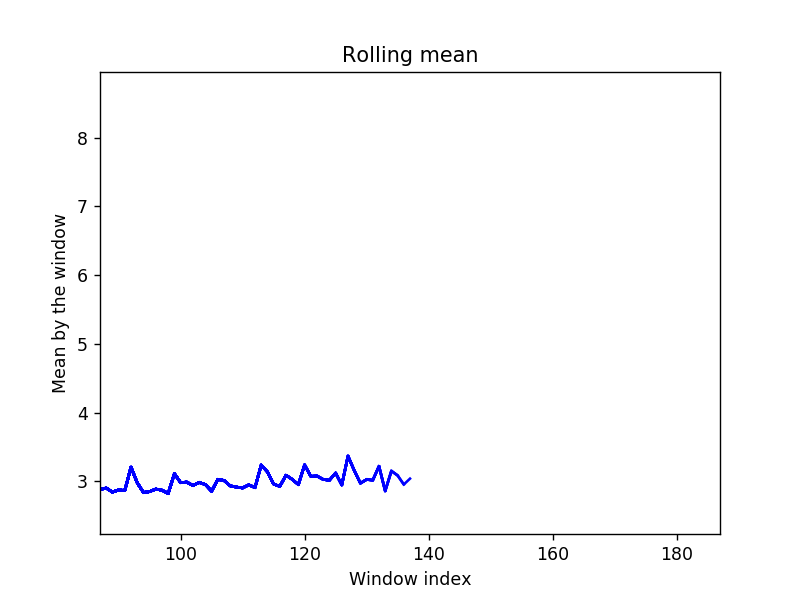

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

In [61]:
obj = RollingMean(window)

In [62]:
for ix,link in enumerate(links):
    match = re.search('\d{4}-\d{2}', link)
    input_date = datetime.datetime.strptime(match.group(), '%Y-%m').date()
    with closing(requests.get(link, stream=True)) as r:
        reader = csv.reader(codecs.iterdecode(r.iter_lines(),'utf-8') )
        for row in reader:
            if row and ('trip_distance' not in row):
                  obj.process_data(row,input_date)
    if ix == number_of_documents-1:
        break

(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14'], 2.6350591237740266) 

(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-0

(['2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27'], 2.8084065578447293) 

(['2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-0

(['2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12'], 2.7761659026495544) 

(['2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-0

(['2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25'], 2.8002703637477135) 

(['2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-0

(['2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07'], 2.8055605295100556) 

(['2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-0

(['2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20'], 2.6377942677001043) 

(['2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-0

(['2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-04'], 2.859665052585083) 

(['2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04

(['2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16'], 2.9790521994868624) 

(['2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2018-0

(['2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29'], 3.026086593009709) 

(['2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27', '2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05

(['2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-23', '2018-06-28'], 2.951622004772687) 

(['2018-04-29', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21', '2018-05-22', '2018-05

(['2018-05-11', '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-28'], 3.2189795343717815) 

(['2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15', '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23', '2018-05-24', '2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-0

In [63]:
# obj.rolling_mean_results

In [64]:
# print("Corrections...")
# obj.corrections

In [65]:
# obj.late